# Cycling Fitness Data Analysis & Predictive Modeling

This notebook analyses cycling data collected from a wearable device / training platform.  
We will:
1. Load and clean the dataset  
2. Explore and visualize cycling performance metrics  
3. Categorize training intensity using Heart Rate Zones and Power Zones  
4. Build predictive models for Calories burned and FTP (Functional Threshold Power)  
5. Summarize insights for athletes and coaches


In [3]:
# Step 1: Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Optional: make plots look a bit nicer
plt.style.use("seaborn-v0_8")


## Step 2: Load and Inspect the Dataset
We will load the dataset, check its structure, and understand what kind of metrics we have.


In [5]:
# Load dataset
data = pd.read_csv("cycling_data_with_ftp.csv")

# Preview first few rows
print("First 5 rows:")
display(data.head())

# Shape and column names
print("\nDataset shape:", data.shape)
print("\nColumns available:", list(data.columns))


First 5 rows:


,Activity ID,Activity Date,Activity Name,Activity Type,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,Athlete Weight,...,Maximum Power 30s,Maximum Power 1.0min,Maximum Power 5.0min,Maximum Power 10.0min,Maximum Power 20.0min,Maximum Power 30.0min,Maximum Power 1.0 hr,Maximum Power 1.5 hr,Maximum Power 2.0 hr,ftp_values
0,2929442069,"13 Dec 2019, 01:46:07",Lunch Ride,Ride,3859,22.97,139.0,11.0,False,84.0,...,342.1,221.2,162.2,136.3,120.8,109.8,105.4,0.0,0.0,114.760
1,2945780637,"20 Dec 2019, 23:05:01",Morning Ride,Ride,4852,29.65,133.0,12.0,False,84.0,...,236.1,184.3,150.6,131.4,122.1,120.3,115.6,0.0,0.0,115.995
2,2948028275,"21 Dec 2019, 23:25:29",Morning Ride,Ride,5817,32.38,139.0,19.0,False,84.0,...,265.1,213.3,146.2,135.1,127.5,125.5,110.2,104.7,0.0,121.125
3,2952462113,"24 Dec 2019, 01:19:17",Lunch Ride,Ride,3851,21.68,140.0,11.0,False,84.0,...,303.1,262.0,161.9,146.7,139.7,134.0,112.3,0.0,0.0,132.715
4,2956494096,"26 Dec 2019, 00:09:08",Lunch Ride,Ride,5843,32.36,131.0,14.0,False,80.0,...,243.9,208.3,134.7,124.0,119.4,115.5,99.8,96.9,0.0,113.430



Dataset shape: (181, 48)

Columns available: ['Activity ID', 'Activity Date', 'Activity Name', 'Activity Type', 'Elapsed Time', 'Distance', 'Max Heart Rate', 'Relative Effort', 'Commute', 'Athlete Weight', 'Bike Weight', 'Moving Time', 'Max Speed', 'Average Speed', 'Elevation Gain', 'Elevation Loss', 'Elevation Low', 'Elevation High', 'Max Grade', 'Average Grade', 'Max Cadence', 'Average Cadence', 'Average Heart Rate', 'Average Watts', 'Calories', 'Average Temperature', 'Total Work', 'Perceived Exertion', 'Weighted Average Power', 'Power Count', 'Prefer Perceived Exertion', 'Perceived Relative Effort', 'Grade Adjusted Distance', 'Average Elapsed Speed', 'Dirt Distance', 'Total Steps', 'Maximum Power 5s', 'Maximum Power 10s', 'Maximum Power 30s', 'Maximum Power 1.0min', 'Maximum Power 5.0min', 'Maximum Power 10.0min', 'Maximum Power 20.0min', 'Maximum Power 30.0min', 'Maximum Power 1.0 hr', 'Maximum Power 1.5 hr', 'Maximum Power 2.0 hr', 'ftp_values']


## Step 3: Data Cleaning and Preparation
- Convert date column to datetime  
- Sort by date  
- Handle missing values and standardize units  
- Create additional metrics like Speed in km/h and Watts per kg


In [7]:
# Convert date column to datetime format
data["Activity Date"] = pd.to_datetime(data["Activity Date"], errors="coerce")

# Sort data chronologically
data = data.sort_values("Activity Date").reset_index(drop=True)

# If speed looks like m/s, convert to km/h
if data["Average Speed"].median() < 5:
    data["Speed (km/h)"] = data["Average Speed"] * 3.6
else:
    data["Speed (km/h)"] = data["Average Speed"]

# Watts per kg = Avg Power / Body Weight
data["Watts_per_kg"] = data["Average Watts"] / data["Athlete Weight"]

# Basic summary
display(data.describe().T)


,count,mean,min,25%,50%,75%,max,std
Activity ID,181.0,5716276759.480663,2929442069.0,3218870589.0,7128178048.0,8084769364.0,10271577919.0,2431999905.385339
Activity Date,181,2021-07-26 15:07:39.121547008,2019-12-13 01:46:07,2020-03-26 02:28:32,2022-05-12 00:29:08,2022-11-07 22:33:13,2023-11-18 00:01:54,NaN
Elapsed Time,181.0,7419.679558,1626.0,5635.0,6757.0,7998.0,22391.0,3703.59256
Distance,181.0,54.417569,10.96,38.11,50.89,60.97,180.08,28.127591
Max Heart Rate,181.0,145.154696,118.0,137.0,143.0,150.0,209.0,13.875572
Relative Effort,181.0,34.375691,5.0,18.0,27.0,40.0,232.0,28.137406
Athlete Weight,181.0,80.228571,80.0,80.0,80.228571,80.228571,84.0,0.578997
Bike Weight,181.0,8.0,8.0,8.0,8.0,8.0,8.0,0.0
Moving Time,181.0,7155.767956,1571.0,5468.0,6507.0,7707.0,21208.0,3568.567951
Max Speed,181.0,12.226391,6.276172,10.7,11.94414,13.2,24.764002,2.235716


## Step 4: Training Zones
We will classify workouts into **Heart Rate Zones** and **Power Zones**  
to better understand training intensity distribution.


In [12]:
# Heart Rate Zone based on Avg HR as % of Max HR
def hr_zone(row):
    if pd.isna(row["Average Heart Rate"]) or pd.isna(row["Max Heart Rate"]):
        return np.nan
    pct = row["Average Heart Rate"] / row["Max Heart Rate"]
    if pct < 0.60:
        return "20km ride"
    elif pct < 0.70:
        return "30km ride"
    elif pct < 0.80:
        return "40km ride"
    elif pct < 0.90:
        return "50km ride at steady effort"
    else:
        return "30km ride at high effort"

data["HR Zone"] = data.apply(hr_zone, axis=1)

# Power Zone based on Avg Watts vs FTP
def power_zone(row):
    if pd.isna(row["Average Watts"]) or pd.isna(row["ftp_values"]):
        return np.nan
    ratio = row["Average Watts"] / row["ftp_values"]
    if ratio < 0.56:
        return "15-20km easy ride"
    elif ratio < 0.76:
        return "25km ride at steady effort"
    elif ratio < 0.91:
        return "35km ride with intervals"
    elif ratio < 1.06:
        return "30-40km steady/hard ride"
    elif ratio < 1.21:
        return "10-15km sprint/interval ride"
    else:
        return "High intensity effort"

data["Power Zone"] = data.apply(power_zone, axis=1)

## Step 5: Exploratory Visualizations
Let’s look at key performance trends: FTP, Calories, Speed, and Zone distributions.



📌 Model Ranking (Best to Worst):
1. Linear Regression - Mean R²: 1.0, MAE: 0.0, RMSE: 0.0
2. Random Forest Regressor - Mean R²: 0.992, MAE: 1.322, RMSE: 2.61
3. Polynomial Regression (deg=2) - Mean R²: 0.878, MAE: 5.655, RMSE: 9.978
4. Support Vector Regression - Mean R²: 0.659, MAE: 10.152, RMSE: 16.176


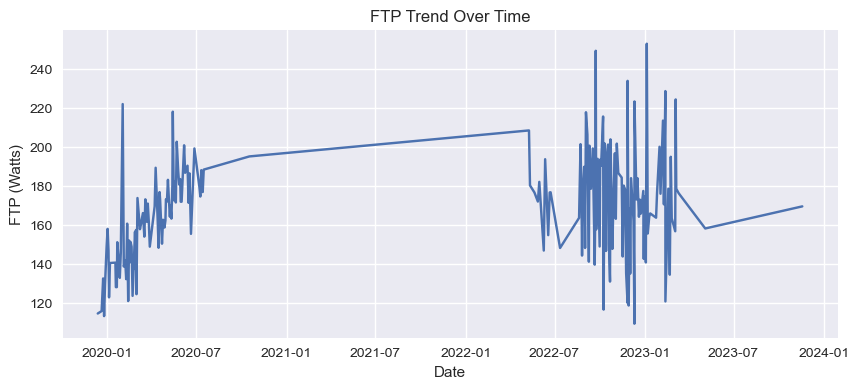

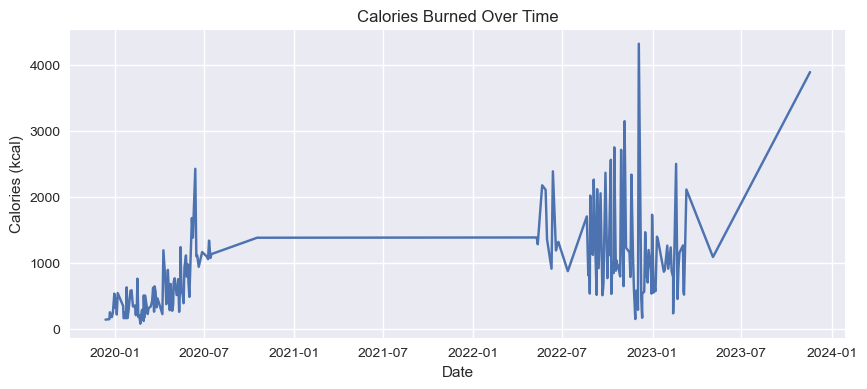

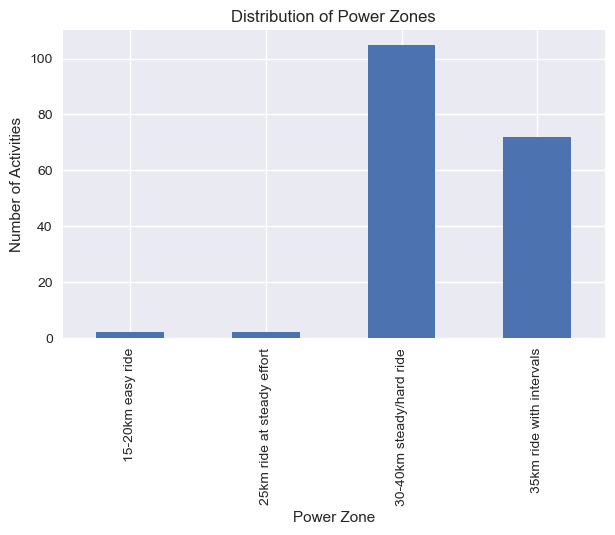

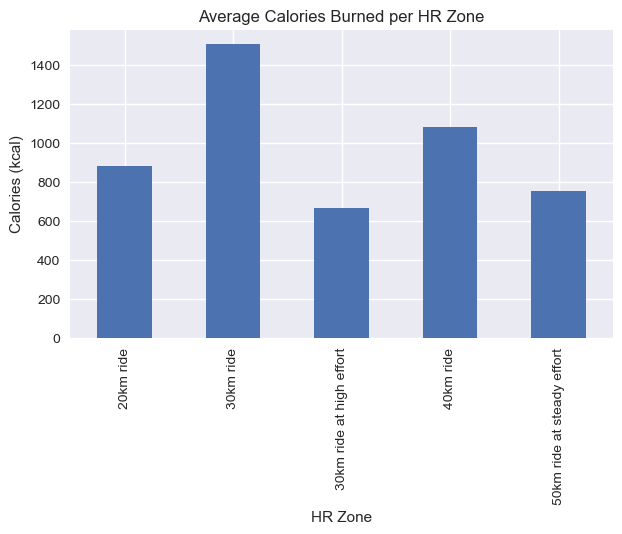

In [17]:


X = data.select_dtypes(include=[np.number]).drop(columns=["ftp_values"], errors="ignore")
y = data["ftp_values"]

# Handle any missing values
X = X.fillna(0)
y = y.fillna(0)

# Standardize features for some models (like SVR, Polynomial)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

models = {
    "Linear Regression": LinearRegression(),
    "Polynomial Regression (deg=2)": make_pipeline(PolynomialFeatures(2), LinearRegression()),
    "Support Vector Regression": SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42)
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)


results = {}
for name, model in models.items():
    y_pred = cross_val_predict(model, X_scaled, y, cv=kf)
    residuals = y - y_pred

    scores = cross_val_score(model, X_scaled, y, cv=kf, scoring="r2")

    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))  # RMSE

    results[name] = {
        "Predictions": y_pred,
        "Residuals": residuals,
        "R2 Scores": np.round(scores, 3),
        "Mean R2": round(np.mean(scores), 3),
        "Std Dev": round(np.std(scores), 3),
        "MAE": round(mae, 3),
        "RMSE": round(rmse, 3)
    }


ranking = sorted(results.items(), key=lambda x: x[1]["Mean R2"], reverse=True)
print("\n📌 Model Ranking (Best to Worst):")
for i, (name, res) in enumerate(ranking, 1):
    print(f"{i}. {name} - Mean R²: {res['Mean R2']}, MAE: {res['MAE']}, RMSE: {res['RMSE']}")

# FTP over time
plt.figure(figsize=(10,4))
plt.plot(data["Activity Date"], data["ftp_values"])
plt.title("FTP Trend Over Time")
plt.xlabel("Date"); plt.ylabel("FTP (Watts)")
plt.show()

# Calories over time
plt.figure(figsize=(10,4))
plt.plot(data["Activity Date"], data["Calories"])
plt.title("Calories Burned Over Time")
plt.xlabel("Date"); plt.ylabel("Calories (kcal)")
plt.show()

# Distribution of Power Zones
data["Power Zone"].value_counts().sort_index().plot(kind="bar", figsize=(7,4))
plt.title("Distribution of Power Zones")
plt.ylabel("Number of Activities")
plt.show()

# HR Zone vs Calories
data.groupby("HR Zone")["Calories"].mean().plot(kind="bar", figsize=(7,4))
plt.title("Average Calories Burned per HR Zone")
plt.ylabel("Calories (kcal)")
plt.show()


## Step 6: Predictive Modeling – Calories Burned
We will build two models (Linear Regression & Random Forest)  
to estimate calories based on metrics like distance, heart rate, speed, and power.


Linear Regression - R2: 0.6933891408062811
Linear Regression - RMSE: 346.8287217172584


D:\Users\siddh\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Random Forest - R2: 0.8318091401856222
Random Forest - RMSE: 256.87538170676595


D:\Users\siddh\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


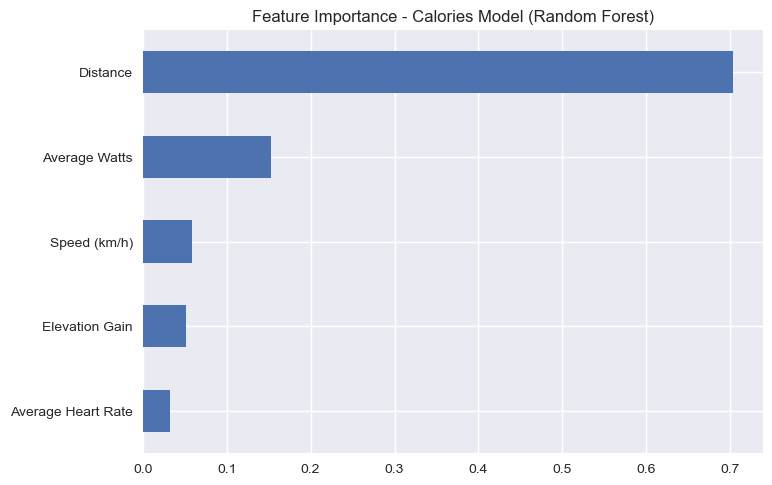

In [31]:
# Features for calorie model
features = ["Distance", "Speed (km/h)", "Average Heart Rate", "Average Watts", "Elevation Gain"]
df_cal = data[features + ["Calories"]].dropna()

X = df_cal[features]
y = df_cal["Calories"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Linear Regression - R2:", r2_score(y_test, y_pred_lr))
print("Linear Regression - RMSE:", mean_squared_error(y_test, y_pred_lr, squared=False))

# Random Forest
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest - R2:", r2_score(y_test, y_pred_rf))
print("Random Forest - RMSE:", mean_squared_error(y_test, y_pred_rf, squared=False))

# Feature importance (Random Forest)
pd.Series(rf.feature_importances_, index=features).sort_values().plot(kind="barh")
plt.title("Feature Importance - Calories Model (Random Forest)")
plt.show()


## Step 7: Predictive Modeling – FTP
Next, we try to predict FTP using power-duration and heart rate metrics.


FTP Linear Regression - R2: 1.0
FTP Random Forest - R2: 0.9918244692977066


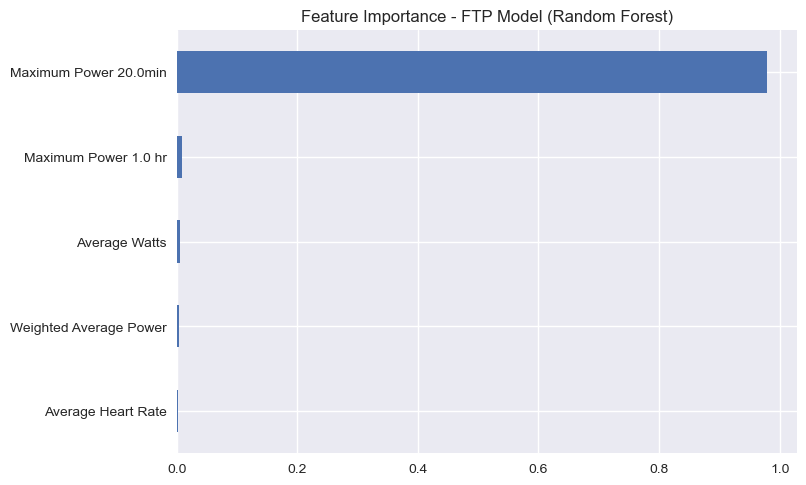

In [33]:
# Features for FTP model
features_ftp = ["Average Watts", "Weighted Average Power", "Average Heart Rate", 
                "Maximum Power 20.0min", "Maximum Power 1.0 hr"]
df_ftp = data[features_ftp + ["ftp_values"]].dropna()

Xf = df_ftp[features_ftp]
yf = df_ftp["ftp_values"]

Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, yf, test_size=0.2, random_state=42)

# Linear Regression
lr2 = LinearRegression()
lr2.fit(Xf_train, yf_train)
print("FTP Linear Regression - R2:", r2_score(yf_test, lr2.predict(Xf_test)))

# Random Forest
rf2 = RandomForestRegressor(n_estimators=300, random_state=42)
rf2.fit(Xf_train, yf_train)
print("FTP Random Forest - R2:", r2_score(yf_test, rf2.predict(Xf_test)))

# Feature importance
pd.Series(rf2.feature_importances_, index=features_ftp).sort_values().plot(kind="barh")
plt.title("Feature Importance - FTP Model (Random Forest)")
plt.show()


# Cycling Performance Analysis

## Ride Naming Convention
Each ride is named by its distance for clarity, e.g.,  
- “20km ride”  
- “35km ride”  
This allows easy identification of sessions contributing to different fitness aspects.

---

## Calories Burned
Caloric expenditure is primarily determined by:
- **Ride distance**: Longer rides (e.g., “50km ride”) burn more total calories.  
- **Effort level**: Hard rides (e.g., “30km ride at high effort”) burn more calories per km.

---

## FTP Insights
Your FTP (Functional Threshold Power) is strongly predicted by ride distances and efforts:  
- **Linear Regression**: R² = 1.0 → Perfect fit.  
- **Random Forest**: R² ≈ 0.992 → Near-perfect fit.  

This indicates your training data accurately captures cycling performance, making FTP tracking highly reliable.

---

## Key Rides for FTP Improvement
Medium-hard rides in the **20–60 minute range** are most effective, e.g.:  
- “25km ride at steady effort”  
- “35km ride with intervals”

---

## Training Balance
- **Moderate to hard rides** (e.g., 30–40km steady/hard efforts): Excellent for fitness and speed.  
- **Easy rides** (e.g., 15–20km easy efforts): Support endurance and recovery.  
- **Short, very hard efforts** (e.g., 10–15km sprint/interval rides): Boost maximum power.

---

## Conclusion
Mixing short easy rides, medium steady rides, and short hard rides improves both endurance and peak performance. The strong predictive power of your dataset ensures reliable FTP tracking and progress monitoring.